In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from nose.tools import *

from scipy.stats import ttest_ind

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# People's activity in Bulgaria

### According to the leaked data from NAP

#### By Kaloyan Zlatkov

## Abstract

TODO

### 1) Definition of hypothesis

My hypothesis is that there is some non-uniform and interesting distribution among the people, their income, their gender, their age in relation to different activities. I think that this NAP leakage is autrageous and far from funny so even though I like funny pictures and memes, I don't think that anything like this is appropriate. This data is very very sad not only because of the data itself, but also when you think that these are real people, who's private data is everywhere on the Internet. So I'm asking the reader not to distribute any private data he might find in this study. I tried to keep the dignity of the people as much as I could and hope that the reader will do the same.

### 2) Analysis of retiring people
The law states that there are some conditions regarding the retirement rights of each person, depending on it's years of labor service, it's age and sex. Each person gets some points (the sum of his/her age and his/her labor service years) and in accordance of his/her gender he/she has rights to retire or not. Of course the points may not be enough. For example if the person is working from very early and has huge amount of labor service years, he/she might still not be liable to retire if he/she doesn't have enough age. Because of that one can assume that retirements that are too early should not be a lot and because in our poor country a lot of retired people continue to work even after retirement - there should be some shifting towared more older people, retiring at some point of time (older than those who complete the requirements of the law). So my prediction is that there will be some highly shifted gaussian distribution towards older people. 
If we take for example year 2015, according to the law, the womnen needed 95.7 points from which 60 years and 8 months age and 35 years labour years. For the men the poins are 101.7, with 63 years and 8 months age and 38 years labor years.

#### 2.1) Analysis of the table with the salaries
According to the data from NAP, on 2015-05-18, 17603 retiring people were written down in the database. Here are their montly incomes/salaries:

In [3]:
retiring_income_data = pd.read_csv("data/MINFIN_BREACH/AEOI/AMOUNT.csv")

In [4]:
retiring_income_data.shape

(17603, 7)

In [5]:
retiring_income_data.dtypes

AMOUNT_ID        int64
CURRENCY_ID      int64
AMOUNT         float64
CREATED_BY      object
CREATED_ON      object
MODIFIED_BY    float64
MODIFIED_ON    float64
dtype: object

In [6]:
retiring_income_data.head()

,AMOUNT_ID,CURRENCY_ID,AMOUNT,CREATED_BY,CREATED_ON,MODIFIED_BY,MODIFIED_ON
0,441,14,1552.98,NSSI_PEN,2015-05-18 16:42:22.000000,NaN,NaN
1,442,14,80.00,NSSI_PEN,2015-05-18 16:42:22.000000,NaN,NaN
2,443,14,1827.00,NSSI_PEN,2015-05-18 16:42:22.000000,NaN,NaN
3,444,14,1473.18,NSSI_PEN,2015-05-18 16:42:22.000000,NaN,NaN
4,445,14,60.00,NSSI_PEN,2015-05-18 16:42:22.000000,NaN,NaN


From all these columns the interesting ones are: 
- AMOUNT_ID - this will be the connection between this table and the other ones, maybе getting the real names and other information about these people. I will rename it as "amount_id"
- AMOUNT - it is not specified what amout that might be (as there is not column information in the leaked data obviously) but my guess is that this is the amount of monthly income (the official income, over which the pension and health payments were made). Usually this income is the last salary of the person, so I will rename it as "salary"
- CURRENCY_ID - this is obviously the currency of the described salary. I will check how many currecnies are there:

In [7]:
retiring_income_data.CURRENCY_ID.unique()

array([14], dtype=int64)

It seems that there is only one currency in this table with CURRENCY_ID == 14. The chances that this is not BGN is very low, but I will check in one of the other tables, named "CURRENCY":

In [8]:
currencies_data = pd.read_csv("data/MINFIN_BREACH/AEOI/CURRENCY.csv")

In [9]:
currencies_data.head()

,CURRENCY_ID,CODE,CREATED_BY,CREATED_ON,MODIFIED_BY,MODIFIED_ON
0,1,AED,init,2014-11-07 09:16:51.000000,init,2014-11-07 09:16:51.000000
1,2,AFN,init,2014-11-07 09:16:51.000000,init,2014-11-07 09:16:51.000000
2,3,ALL,init,2014-11-07 09:16:51.000000,init,2014-11-07 09:16:51.000000
3,4,AMD,init,2014-11-07 09:16:51.000000,init,2014-11-07 09:16:51.000000
4,5,ANG,init,2014-11-07 09:16:51.000000,init,2014-11-07 09:16:51.000000


In [10]:
currencies_data[currencies_data['CURRENCY_ID'] == 14]

,CURRENCY_ID,CODE,CREATED_BY,CREATED_ON,MODIFIED_BY,MODIFIED_ON
13,14,BGN,init,2014-11-07 09:16:51.000000,init,2014-11-07 09:16:51.000000


After I confirmed that the currency is BGN and that there aren't any other currencies, I will remove the CURRENCY_ID column and just rename the AMOUNT column "salary_BGN". Also the rest of the columns (CREATED_BY, CREATED_ON, MODIFIED_BY, MODIFIED_ON) are not interesting for me (the modified date is the same as the created date, the MODIFIED_BY column is full only of NaN:

In [11]:
retiring_income_data.CREATED_BY.unique()

array(['NSSI_PEN'], dtype=object)

In [12]:
retiring_income_data.MODIFIED_BY.unique()

array([nan])

In [13]:
retiring_income_data_renamed = retiring_income_data.drop(['CURRENCY_ID', 'CREATED_BY', 'MODIFIED_BY', 'MODIFIED_ON'], axis=1)

In [14]:
retiring_income_data_renamed.columns = ["amount_id", "salary_BGN", "created_on"]

In [15]:
retiring_income_data_renamed.head()

,amount_id,salary_BGN,created_on
0,441,1552.98,2015-05-18 16:42:22.000000
1,442,80.00,2015-05-18 16:42:22.000000
2,443,1827.00,2015-05-18 16:42:22.000000
3,444,1473.18,2015-05-18 16:42:22.000000
4,445,60.00,2015-05-18 16:42:22.000000


In [16]:
retiring_income_data_renamed.isna().any()

amount_id     False
salary_BGN    False
created_on    False
dtype: bool

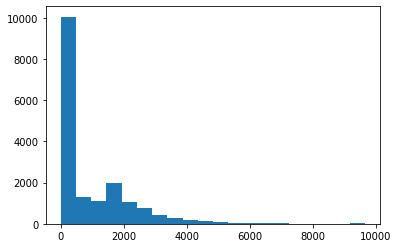

In [17]:
plt.hist(retiring_income_data_renamed.salary_BGN, bins = 20)
plt.show()

It is clear and expected - that the income of the retiring people in Bulgaria is very low and that the poor people are majority :( 

OK now I will leave this table and take a look at the next one

#### 2. 2) Analysis of the table with the EGNs
According to NAP the same 17603 retired people have the following additional data:

In [18]:
pension_recipients = pd.read_csv("data/MINFIN_BREACH/AEOI/PEN_RECIPIENT.csv")

In [19]:
pension_recipients.shape

(17603, 12)

In [20]:
pension_recipients.head()

,DOCREFID,MESSAGE_ID,CORRDOCREFID,PEN_RECIPIENT_ID,NATURAL_PERSON_ID,REPRESENTATIVE_ID,CREATED_BY,CREATED_ON,MODIFIED_BY,MODIFIED_ON,RECIPIENT_NUMBER,INFORMATION_STATUS
0,PEN_NSSI2014-12-31536,203,NaN,203,203,NaN,NSSI_PEN,2015-05-18 16:42:19.000000,NaN,NaN,3201034369,new
1,PEN_NSSI2014-12-31537,204,NaN,204,204,NaN,NSSI_PEN,2015-05-18 16:42:19.000000,NaN,NaN,4807314376,new
2,PEN_NSSI2014-12-31538,205,NaN,205,205,NaN,NSSI_PEN,2015-05-18 16:42:19.000000,NaN,NaN,4807314376,new
3,PEN_NSSI2014-12-31539,206,NaN,206,206,NaN,NSSI_PEN,2015-05-18 16:42:19.000000,NaN,NaN,4807314376,new
4,PEN_NSSI2014-12-31540,207,NaN,207,207,NaN,NSSI_PEN,2015-05-18 16:42:19.000000,NaN,NaN,3606184474,new


In [21]:
pension_recipients.dtypes

DOCREFID               object
MESSAGE_ID              int64
CORRDOCREFID          float64
PEN_RECIPIENT_ID        int64
NATURAL_PERSON_ID       int64
REPRESENTATIVE_ID     float64
CREATED_BY             object
CREATED_ON             object
MODIFIED_BY           float64
MODIFIED_ON           float64
RECIPIENT_NUMBER        int64
INFORMATION_STATUS     object
dtype: object

In [22]:
pension_recipients.isna().any()

DOCREFID              False
MESSAGE_ID            False
CORRDOCREFID           True
PEN_RECIPIENT_ID      False
NATURAL_PERSON_ID     False
REPRESENTATIVE_ID      True
CREATED_BY            False
CREATED_ON            False
MODIFIED_BY            True
MODIFIED_ON            True
RECIPIENT_NUMBER      False
INFORMATION_STATUS    False
dtype: bool

In [23]:
pension_recipients.CORRDOCREFID.unique()

array([nan])

In [24]:
pension_recipients.REPRESENTATIVE_ID.unique()

array([nan])

In [25]:
pension_recipients.MODIFIED_BY.unique()

array([nan])

In [26]:
pension_recipients.MODIFIED_ON.unique()

array([nan])

In [27]:
pension_recipients.INFORMATION_STATUS.unique()

array(['new'], dtype=object)

In [28]:
pension_recipients.CREATED_BY.unique()

array(['NSSI_PEN'], dtype=object)

It seems that a lof of the columns are either full with NaN values only or with just a single value which is not relevant to our study. Also I will not use the column DOCREFID as I don't have access to the docs send. Also the columns MESSAGE_ID, PEN_RECIPIENT_ID and NATURAL_PERSON_ID are with the same value and can be combined into one feature:

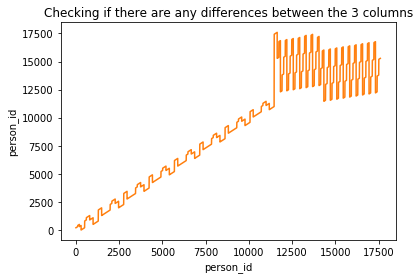

In [29]:
plt.plot(pension_recipients.NATURAL_PERSON_ID, pension_recipients.REPRESENTATIVE_ID, pension_recipients.MESSAGE_ID)
plt.title("Checking if there are any differences between the 3 columns")
plt.xlabel("person_id")
plt.ylabel("person_id")
plt.show()

In [30]:
pension_recipients_renamed = pension_recipients.drop(['MESSAGE_ID', 'DOCREFID', 'CORRDOCREFID', 'NATURAL_PERSON_ID', 'REPRESENTATIVE_ID', 'CREATED_BY', 'MODIFIED_BY', 'MODIFIED_ON', 'INFORMATION_STATUS'], axis=1)

In [31]:
pension_recipients_renamed.columns

Index(['PEN_RECIPIENT_ID', 'CREATED_ON', 'RECIPIENT_NUMBER'], dtype='object')

In [32]:
pension_recipients_renamed.columns = ["retiring_person_id", "created_on", "EGN"]

In [33]:
pension_recipients_renamed.head()

,retiring_person_id,created_on,EGN
0,203,2015-05-18 16:42:19.000000,3201034369
1,204,2015-05-18 16:42:19.000000,4807314376
2,205,2015-05-18 16:42:19.000000,4807314376
3,206,2015-05-18 16:42:19.000000,4807314376
4,207,2015-05-18 16:42:19.000000,3606184474


According to the laws and rules in Bulgaria regarding the citizen's unique id number (the so called EGN) the numbers are formulated like this:
- the first 2 digits are the year of birth. Both 1900 and 2000 are with digits 00
- the 3rd and 4th digits are the month of birth. If you're born before 1st of January 1900, the number 20 is added to your month digits (i.e. if you're born on April 1890, you get 9025 as starting 4 digits of your EGN). If you're born after 31th of Deceber 1999, the number 40 is added to your month digits (i.e. if you're born on April 2008, you get 0845 as starting 4 digits of your EGN))
- the 5th and the 6th digits are the day of birth.
- the 7th, 8th and 9th digits are holding information about the region in Bulgaria where the birth took place. The 7th and the 8th digits are randomly generated and the 9th digit is even for boys and odd for girls.
- the last 10th number is "control number" and is calculated following this algorithm:
    - there is a weighted number for each 9 positions previously explained. Each of this weighted number is multiplied with the number of a concrete person (on the concrete positions). The result is divided by 11 and the remainder is taken (like n % 11 in most coding languages). If the result is < 10, it is taken as a control number, otherwise the number 0 is taken. Because I'm working with real people's data and EGN I feel morally obligated to test and demonstrate this number with my own EGN, which is 8504027065:

| Position | Weight | My EGN numbers | Multiplication result |
|----------|--------|----------------|-----------------------|
| 1        | 2      | 8              | 16                    |
| 2        | 4      | 5              | 20                    |
| 3        | 8      | 0              | 0                     |
| 4        | 5      | 4              | 20                    |
| 5        | 10     | 0              | 0                     |
| 6        | 9      | 2              | 18                    |
| 7        | 7      | 7              | 49                    |
| 8        | 3      | 0              | 0                     |
| 9        | 6      | 6              | 36                    |

        The sum is 159 and:

In [34]:
159 % 11

5

And it turnes out that my EGN in relation to this algorithm is correct, thanks god! Also there are strange EGN values as min and max. Maybe the max value is for some kid with health problems that gets some pension - I don't have any  other explanation. Regarding the min value - it is some mistake in my opinion - there cannot be 6-digit EGNs:

In [35]:
pension_recipients_renamed.EGN.max()

9911264386

In [36]:
pension_recipients_renamed.EGN.min()

171171

In [37]:
pension_recipients_renamed.EGN.mean()

4600648945.152133

In [38]:
pension_recipients_renamed.EGN.median()

4610176249.0

In [39]:
pension_recipients_renamed.EGN.mode()

0    4001160079
dtype: int64

In [40]:
pension_recipients_renamed.EGN.skew()

0.5181221263498235

In [41]:
def show_histogram(dataframe, column, binZ):
    plt.figure(figsize = (12, 6))
    plt.hist(dataframe[column], bins = binZ)
    plt.title("{} distribution amongst the retired people on 18.05.2015".format(column))
    plt.xlabel("{} as a real number".format(column))
    plt.ylabel("Count")
    plt.show()

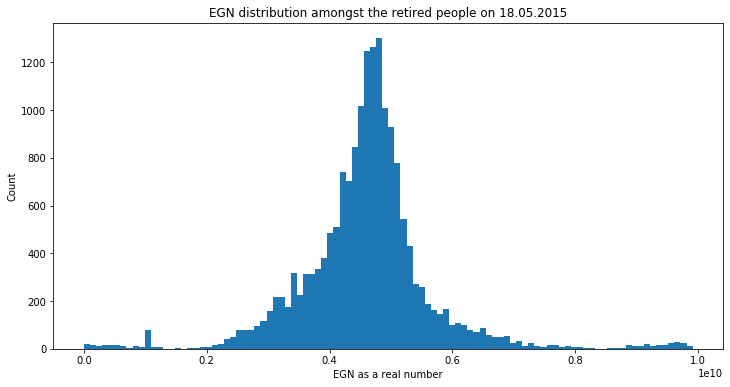

In [42]:
show_histogram(pension_recipients_renamed, "EGN", 100)

The results are very interesting for me.
- First: there are obviously more wrong data in the left part of the distribution (EGNs with number of digits < 10) I will try to filter them
- Second: there are some pentions for very young people (with EGN starting with 90) - maybe I have to make firther investigation on that fact
- Thired: there is very small skew and this distribution is very close to normal distribution.
- Fourth: I never thought before but actually the left shift is very logical. The people to the right are maybe people from category 1 and 2 that can retire at much younger age. There are some but not so far away. On the left side however there are much more people. This means that people, much more older than 60/63 years old have made a decision for late retirement (later than their age requirement). This could be because they were missing points (they had the age but were missing the labor service years) OR they have the points and everything but just decided not to retire and continue working for much higher income. We can check this second theory by taking a look at the income from the first table and making connection between the two tables.
But before mixing tables I'll try to extract the gender and make some function for birth year extraction as well as it is the most relevant for me. I plan to ignore the rest of the EGN data later on.

In [43]:
MINIMUM_EGN_VALUE = 1000000000

In [44]:
pension_recipients_filtered = pension_recipients_renamed.loc[pension_recipients_renamed.EGN >= MINIMUM_EGN_VALUE]

In [45]:
pension_recipients_renamed.shape

(17603, 3)

In [46]:
pension_recipients_filtered.shape

(17475, 3)

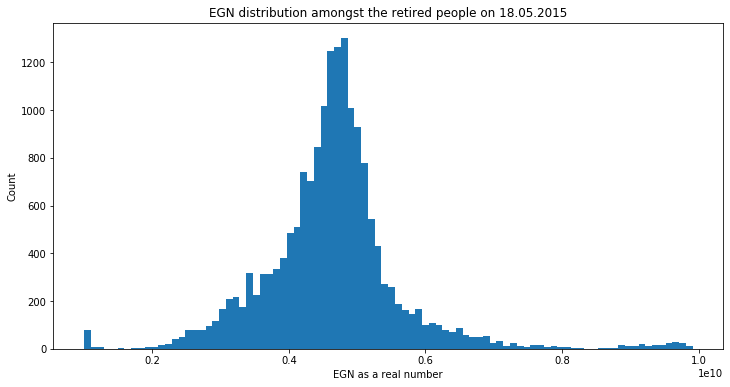

In [47]:
show_histogram(pension_recipients_filtered, "EGN", 90)

In [48]:
filtered_data = 100 * (pension_recipients_renamed.shape[0] - pension_recipients_filtered.shape[0]) / pension_recipients_renamed.shape[0]
print("The deleted data by filtered wrong EGNs is {:.2f}%".format(filtered_data))

The deleted data by filtered wrong EGNs is 0.73%


Ok, after filtering the wrong data we can take a closer look at the younger people (I will take the threshold 80's because this means 35 years in 2015, maybe reasonable for some miners or other people with category 1):

In [49]:
THRESHOLD_FOR_RIGHT_OUTLIERS = 8000000000
young_retired_people = pension_recipients_filtered[pension_recipients_filtered.EGN > THRESHOLD_FOR_RIGHT_OUTLIERS]
retired_with_regular_age = pension_recipients_filtered[pension_recipients_filtered.EGN <= THRESHOLD_FOR_RIGHT_OUTLIERS]

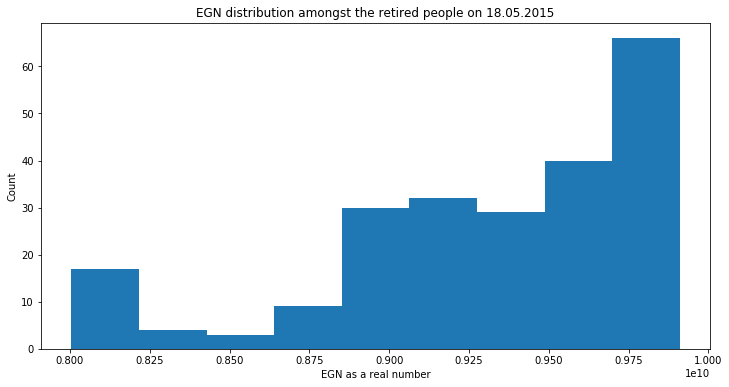

In [50]:
show_histogram(young_retired_people, "EGN", 'fd')

In [51]:
pension_recipients_renamed[pension_recipients_renamed.EGN <= MINIMUM_EGN_VALUE].shape

(128, 3)

So my theory is that these 128 entries with EGN with number of digits < 10 are not incorrect, but are rather with leading zeroes (and from NAP did not take adequate decision making the EGN values int64 and losing these leading digits). So I will try to modify the EGN column by leaving only years

In [52]:
def get_year_XX_century(EGN):
    year = 1900 + np.floor(EGN / 100000000)
    return year

In [53]:
def get_year_XIX_century(EGN):
    year = 1800 + np.floor(EGN / 100000000)
    return year

In [54]:
def get_year_XXI_century(EGN):
    year = 2000 + np.floor(EGN / 100000000)
    return year

In [55]:
def zero_year_correction(EGN, zeroes, century):
    if zeroes == 1:
        return century + np.floor(EGN / 100000000)
    elif zeroes == 2:
        return century + np.floor(EGN / 10000000)
    else:
        return century + np.floor(EGN / 1000000)

In [56]:
def zero_year_check(EGN, century):
    if EGN < 10000000:
        return zero_year_correction(EGN, 3, century)
    elif EGN < 100000000:
        return zero_year_correction(EGN, 2, century)
    else:
        return zero_year_correction(EGN, 1, century)

In [57]:
def get_year_from_EGN(EGN):
    months = np.floor(EGN / 1000000) % 100
    if EGN >= 1000000000:
        if months < 20:
            year = get_year_XX_century(EGN)
        elif months > 40:
            year = get_year_XXI_century(EGN)
        else:
            year = get_year_XIX_century(EGN)
    else:
        if months < 20:
            year = zero_year_check(EGN, 1900)
        elif months > 40:
            year = zero_year_check(EGN, 2000)
        else:
            year = zero_year_check(EGN, 1800)
    return year

In [63]:
assert_equal(1985, get_year_from_EGN(8504027065))
assert_equal(1885, get_year_from_EGN(8524027065))
assert_equal(2085, get_year_from_EGN(8544027065))
assert_equal(1905, get_year_from_EGN(510027065))
assert_equal(1805, get_year_from_EGN(530027065))
assert_equal(2005, get_year_from_EGN(550027065))
assert_equal(1900, get_year_from_EGN(10027065))

AssertionError: 1900 != 1901.0

### Resources:
- http://trudipravo.bg/index.php/znanie-za-vas/1053-tablitzi-za-usloviyata-za-pridobivane-pravo-na-pensiya-za-osiguritelen-stazh-i-vazrast 
- https://bg.wikipedia.org/wiki/%D0%95%D0%B4%D0%B8%D0%BD%D0%B5%D0%BD_%D0%B3%D1%80%D0%B0%D0%B6%D0%B4%D0%B0%D0%BD%D1%81%D0%BA%D0%B8_%D0%BD%D0%BE%D0%BC%D0%B5%D1%80